In [1]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import librosa
import os

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
"""
change the following line maindir to the folder with all the LID files.
maindir contains the folders (assamese, bengali, Gujarathi, Manipuri, Marathi, Odia, Telugu)
Each of these files contains the following folders (train,test)
Train and test folders contain the corresponding train and test samples of that particular language.
"""

maindir="/content/gdrive/MyDrive/sspdata1" 


In [5]:
def zero_frequency_resonator(audio):
    result = np.zeros(audio.shape)
    for i in range(2, len(audio)):
        result[i] = -(-2 * result[i-1] + 1 * result[i-2]) + audio[i]
    return result


def mean_substraction(audio, window_length):
    mean_filter = np.ones(window_length) / window_length
    N = (window_length - 1) // 2
    result = audio[N: -N] - np.convolve(audio, mean_filter, mode="valid")
    return result


def extract_epochs(audio, mean_window_length):
    mean_window_length = mean_window_length + (mean_window_length % 2 == 0)
    x = audio.copy()
    x[1:] = np.diff(audio)
    y1 = zero_frequency_resonator(x)
    y2 = zero_frequency_resonator(y1)
    y = y2.copy()
    for i in range(2): y = mean_substraction(y, mean_window_length)
    GCI = np.nonzero(np.diff(np.sign(y)) > 0)[0]
    return y, GCI
    
def framing(data, window_length, hop_length):
    total_samples = len(data)
    num_frames = 1 + (total_samples - window_length) // hop_length + ((total_samples - window_length) % hop_length != 0)
    frames = np.zeros((num_frames, window_length))
    frame_num = 0
    i = 0
    for i in range(0, total_samples - window_length + 1, hop_length):
        frames[frame_num] = data[i: i+window_length]
        frame_num += 1
    if(frame_num != num_frames):
        i += hop_length
        frames[frame_num][:total_samples-i] = data[i:]
        frame_num += 1
    return frames

def getVoiced(audio, sr):
    SNR = 30
    rms_audio = np.sqrt(np.mean(audio**2))
    std_noise = np.sqrt(rms_audio**2 / np.power(10, SNR / 10))
    mean_window_length = 10 * sr // 1000
    mean_window_length = mean_window_length + (mean_window_length % 2 == 0)
    noise = np.random.normal(0, std_noise, audio.shape)
    noised_1 = audio + noise
    _, GCI1 = extract_epochs(noised_1, mean_window_length)
    noise = np.random.normal(0, std_noise, audio.shape)
    noised_2 = audio + noise
    _, GCI2 = extract_epochs(noised_2, mean_window_length)
    win_len = 512
    frames = framing(audio[mean_window_length-1: -mean_window_length+1], win_len, win_len)
    voiced_audio = []
    count=0
    for i, frame in enumerate(frames):
        start = i * win_len
        end = start + win_len
        gci1 = GCI1[(GCI1 >= start) & (GCI1 <= end)]
        gci2 = GCI2[(GCI2 >= start) & (GCI2 <= end)]
        if gci1.shape[0] <= 1 or gci2.shape[0] <= 1 or \
            gci1.shape != gci2.shape or np.mean(np.abs(gci1 - gci2)) > 7:
            continue
        voiced_audio.extend(frame)
        count=count+1
    print(count,len(frames))
    return np.array(voiced_audio)

def get_LP_res(audio,sr):
    k = sr//1000
    a = librosa.lpc(audio,order=k)
    b = np.hstack([[0], -1*a[1:]])
    y_hat = scipy.signal.lfilter(b, [1], audio)
    LP_res = audio - y_hat
    return LP_res
def extract_pitch_sync_frames(audio,GCI):
    frames=[audio[:GCI[0]]]
    count=0
    for i, epoch in enumerate(GCI):
        try:
            frames.append(audio[epoch:GCI[i+1]])
        except:
            break
    return frames

In [12]:
sr = 16000

for lang in os.listdir(maindir):
  for file in os.listdir(maindir+"/"+lang+"/train"):
    try:
      if not os.path.isdir(maindir+"/"+lang+"/train_mfccfeatures/"):
          os.makedirs(maindir+"/"+lang+"/train_mfccfeatures/")
      filename=maindir+"/"+lang+"/train_mfccfeatures/"+file.split()[0]+".npy"
      if os.path.isfile(filename):
        continue
      channels, sr = librosa.load(maindir+"/"+lang+"/train/"+file, sr=sr)
      audio = channels
      voiced_audio = getVoiced(audio, sr)
      if(len(audio)==0 or len(voiced_audio)==0):
        continue
      
      # LP_res = get_LP_res(voiced_audio,sr)
      LP_res=voiced_audio
      mean_window_length = 10 * sr // 1000
      y, GCI = extract_epochs(LP_res, mean_window_length)
      frames = extract_pitch_sync_frames(voiced_audio, GCI)

      mfcc_features=list()
      for i in range(len(frames)):
        mfcc_coeffs = librosa.feature.mfcc(get_LP_res(frames[i],sr), sr=sr, n_mfcc=13, hop_length=len(frames[i]) + 1, win_length=len(frames[i]))
        mfcc_features.append(mfcc_coeffs.ravel())
      np.array(mfcc_features).ravel()
      
      
      np.save(filename,np.array(mfcc_features))
      print("saved")
    except:
      print("except")
      continue


  for file in os.listdir(maindir+"/"+lang+"/test"):
    try:
      if not os.path.isdir(maindir+"/"+lang+"/test_mfccfeatures/"):
          os.makedirs(maindir+"/"+lang+"/test_mfccfeatures/")
      filename=maindir+"/"+lang+"/test_mfccfeatures/"+file.split()[0]+".npy"
      if os.path.isfile(filename):
        continue
      if(len(audio)==0 or len(voiced_audio)==0):
        continue
      channels, sr = librosa.load(maindir+"/"+lang+"/test/"+file, sr=sr)
      audio = channels
      voiced_audio = getVoiced(audio, sr)
      # LP_res = get_LP_res(voiced_audio,sr)
      LP_res=voiced_audio
      mean_window_length = 10 * sr // 1000
      y, GCI = extract_epochs(LP_res, mean_window_length)
      frames = extract_pitch_sync_frames(voiced_audio, GCI)

      mfcc_features=list()
      for i in range(len(frames)):
        mfcc_coeffs = librosa.feature.mfcc(get_LP_res(frames[i],sr), sr=sr, n_mfcc=13, hop_length=len(frames[i]) + 1, win_length=len(frames[i]))
        mfcc_features.append(mfcc_coeffs.ravel())
      np.array(mfcc_features).ravel()
      
      np.save(filename,np.array(mfcc_features))
    except:
      continue



237 351


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=72
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=299
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=339
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=334
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=209
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=130
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/s

saved
189 294


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=326
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=311
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=260
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=389
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=376
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=161
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
229 322


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=190
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=171
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=109
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=287
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=324
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=321
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
265 335


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=514
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=487
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=380
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=516
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=233
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=286
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
208 288


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=330
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=403
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=457
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=353
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=256
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=244
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
150 245


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=289
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=488
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=32
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=319
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=343
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=34
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/sp

saved
258 361


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=3
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=342
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=246
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=301
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=405
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=345
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/sp

saved
269 339


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=404
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=354
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=550
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=390
  n_fft, y.shape[-1]


saved
156 257


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=374
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=394
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=344
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=327
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=420
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=379
  n_fft, y.shape[-1]


saved
227 307


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=29
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=396
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=26
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=325
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=265
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=455
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/sp

saved
234 313


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=384
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=370
  n_fft, y.shape[-1]


saved
265 333


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=307
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=425
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=397
  n_fft, y.shape[-1]


saved
239 325


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=423
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=378
  n_fft, y.shape[-1]


saved
147 217


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=406
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=424
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=387
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=454
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=350
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=432
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
189 287
except
275 344


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=479
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=538
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=355
  n_fft, y.shape[-1]


saved
223 343


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=438
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=450
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=356
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=437
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=476
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=33
  n_fft, y.shape[-1]


saved
210 307


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=349
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=408
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=407
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=524
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=459
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=436
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/

saved
183 275


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=492
  n_fft, y.shape[-1]


saved
265 329


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=440
  n_fft, y.shape[-1]


saved
283 349


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=749
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=465
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=556
  n_fft, y.shape[-1]


saved
179 277


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=364
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=25
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=313
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=24
  n_fft, y.shape[-1]


saved
227 320
saved
218 288


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=449
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=458
  n_fft, y.shape[-1]


saved
240 302


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=571
  n_fft, y.shape[-1]


saved
240 303
except
176 292


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=351
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=427
  n_fft, y.shape[-1]


saved
196 273


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=402
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=365
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=393
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=530
  n_fft, y.shape[-1]


saved
229 349


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=415
  n_fft, y.shape[-1]


except
269 334
saved
342 417


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=441
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=453
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=439
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=412
  n_fft, y.shape[-1]


saved
281 358


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=493
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=375
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=429
  n_fft, y.shape[-1]


saved
180 258


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=381
  n_fft, y.shape[-1]


saved
267 343


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=447
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=515
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=451
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=504
  n_fft, y.shape[-1]


saved
225 345


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=551
  n_fft, y.shape[-1]


saved
207 269


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=448
  n_fft, y.shape[-1]


saved
274 345


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=485
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=507
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=409
  n_fft, y.shape[-1]


saved
222 294


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=426
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=494
  n_fft, y.shape[-1]


saved
127 197
saved
229 286


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=572
  n_fft, y.shape[-1]


saved
182 297


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=6
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=482
  n_fft, y.shape[-1]


saved
150 220


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=463
  n_fft, y.shape[-1]


saved
210 310


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=496
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=23
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=456
  n_fft, y.shape[-1]


saved
183 267


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=461
  n_fft, y.shape[-1]


saved
256 314


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=445
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=388
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=435
  n_fft, y.shape[-1]


saved
182 309
except
209 264
saved
219 310


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=468
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=560
  n_fft, y.shape[-1]


saved
253 320
saved
271 334
saved
233 280
saved
174 250


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=474
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=500
  n_fft, y.shape[-1]


saved
264 334


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=433
  n_fft, y.shape[-1]


saved
248 324
saved
230 288


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=30
  n_fft, y.shape[-1]


saved
208 294


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=383
  n_fft, y.shape[-1]


saved
201 297
saved
195 311
except
231 278


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=443
  n_fft, y.shape[-1]


saved
251 324


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=656
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=506
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=401
  n_fft, y.shape[-1]


saved
273 366


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=579
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=512
  n_fft, y.shape[-1]


saved
197 291
saved
205 289


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=588
  n_fft, y.shape[-1]


saved
230 349


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=414
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=466
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=483
  n_fft, y.shape[-1]


saved
225 304
except
199 298
saved
278 336
saved
221 326
saved
140 189
saved
237 327


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=486
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=498
  n_fft, y.shape[-1]


saved
197 250
saved
214 318


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=411
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=27
  n_fft, y.shape[-1]


saved
222 347


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=505
  n_fft, y.shape[-1]


saved
148 249
saved
263 302


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=736
  n_fft, y.shape[-1]


saved
192 307


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=491
  n_fft, y.shape[-1]


saved
184 269
saved
293 380
saved
256 311
saved
167 256
186 325


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=508
  n_fft, y.shape[-1]


220 323
272 341


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=547
  n_fft, y.shape[-1]


209 250
244 308
169 255
220 261
196 251


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=18
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=19
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=28
  n_fft, y.shape[-1]


220 326
157 247
200 289


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=421
  n_fft, y.shape[-1]


198 295
225 280


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=523
  n_fft, y.shape[-1]


284 374
164 252
280 340


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=484
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=481
  n_fft, y.shape[-1]


331 384
229 300


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=480
  n_fft, y.shape[-1]


246 312


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=520
  n_fft, y.shape[-1]


100 141


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=471
  n_fft, y.shape[-1]


saved
96 154
except
289 364
saved
85 126
saved
147 250
saved
332 523
except
150 229
except
387 469
saved
349 442
saved
197 233
saved
501 558
saved
647 740
saved
326 384
except
228 346
saved
553 615
saved
407 509
except
203 306
saved
187 229
saved
353 394
saved
460 532
except
422 508
saved
132 189
except
834 945
saved
435 553
saved
134 224
saved
219 332
saved
522 600
saved
139 220
saved
197 295
except
300 370
except
306 500
except
94 117
saved
316 350
saved
163 264


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=16
  n_fft, y.shape[-1]


saved
249 298
saved
330 368
saved
110 163
except
596 662
saved
253 359
saved
142 194
saved
449 505
saved
220 303
saved
69 112
saved
353 402
saved
442 496
saved
520 584


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=511
  n_fft, y.shape[-1]


saved
318 375
saved
565 628
except
320 472
saved
458 511


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=15
  n_fft, y.shape[-1]


saved
341 409
saved
191 280
saved
279 455
saved
251 269
saved
329 454


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=431
  n_fft, y.shape[-1]


except
170 282


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=22
  n_fft, y.shape[-1]


saved
229 326
saved
430 467
saved
85 140
except
286 451
except
133 186
saved
145 173
saved
962 1096
except
103 145
saved
221 325


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=503
  n_fft, y.shape[-1]


saved
195 285
saved
58 79


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=460
  n_fft, y.shape[-1]


saved
394 553
saved
558 668
saved
530 595
saved
241 384
except
367 441
saved
194 225
saved
489 525
saved
133 158
saved
175 251
except
350 538
saved
105 165
saved
148 211


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=17
  n_fft, y.shape[-1]


saved
442 533
saved
1003 1089
144 185
590 665
556 685


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=21
  n_fft, y.shape[-1]


195 216
170 240
145 223
270 317
103 158
152 182
268 314
384 422
177 231
370 409
51 74
214 325


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=20
  n_fft, y.shape[-1]


274 368
83 121
61 87
209 264
91 152


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=12
  n_fft, y.shape[-1]


saved
113 196
saved
218 295
saved
147 264
saved
165 222
saved
102 170
saved
178 213
saved
105 166
saved
163 214
saved
246 383
saved
107 165
saved
178 266
saved
142 279
saved
162 248
saved
63 99
saved
187 267
except
159 206
saved
99 150


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=14
  n_fft, y.shape[-1]


saved
122 208
except
180 240
except
173 230
saved
105 166
saved
181 254
saved
99 180
saved
59 104
saved
158 202
saved
191 350


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=7
  n_fft, y.shape[-1]


saved
153 283
saved
260 388
saved
146 187
saved
74 93
saved
84 171
saved
163 222


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=11
  n_fft, y.shape[-1]


saved
123 198
saved
159 243
saved
185 287


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=13
  n_fft, y.shape[-1]


saved
50 88
saved
151 224
saved
173 240
saved
181 280
except
175 272
saved
113 164
except
166 220
saved
135 198
saved
191 321
saved
180 272
saved
153 197
saved
122 163
saved
178 232
saved
148 195
saved
96 180
saved
46 90
saved
118 184
except
127 232
saved
174 221
saved
113 151
except
204 269
saved
except
64 88
saved
88 143
saved
132 178
saved
73 166
saved
69 91
saved
104 188
saved
82 111
saved
132 206
saved
168 220
saved
201 374
saved
123 169
saved
60 110
except
98 144


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=8
  n_fft, y.shape[-1]


saved
163 243
except
101 133
saved
172 250
saved
124 187


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=10
  n_fft, y.shape[-1]


saved
96 153
saved
104 150
except
87 137
saved
142 188
except
130 253
saved
47 88
70 126
176 264
180 217
67 177
91 161
83 128
169 220
182 250
173 321
92 165
113 141
242 348
131 192
60 147
113 161
75 119
73 104
129 172
96 176
151 258
saved
67 92
saved
71 137
saved
54 103


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=545
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=674
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=593
  n_fft, y.shape[-1]


saved
62 109
except
57 139
saved
108 172
except
76 150
saved
34 61


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=470
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=489
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=553
  n_fft, y.shape[-1]


saved
146 258
saved
68 106
except
24 54
saved
76 127
saved
7 40
saved
49 98


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=477
  n_fft, y.shape[-1]


saved
25 63


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=549
  n_fft, y.shape[-1]


saved
125 221
saved
19 56
except
79 142


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=564
  n_fft, y.shape[-1]


saved
20 48
saved
7 33
saved
86 130
except
81 185


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=475
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=577
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=472
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=469
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=566
  n_fft, y.shape[-1]


saved
90 166
except
10 19
saved
60 113
saved
73 156
saved
45 95
saved
65 101
saved
81 150
except
44 81
saved
44 71
except
51 111


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=634
  n_fft, y.shape[-1]


saved
80 136


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=712
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=499
  n_fft, y.shape[-1]


saved
16 38
saved
80 171
except
146 333
saved
35 66
saved
33 62
saved
52 95


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=615
  n_fft, y.shape[-1]


saved
53 123


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=624
  n_fft, y.shape[-1]


saved
24 68


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=618
  n_fft, y.shape[-1]


saved
24 44
saved
55 95
except
104 172


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=594
  n_fft, y.shape[-1]


saved
153 396
except
37 63
saved
57 124
saved
32 60
except
38 78
except
33 80
except
83 159
except
52 97
except
64 137
except
44 101


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=542
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=653
  n_fft, y.shape[-1]


saved
42 78
except
127 224
saved
53 97


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=576
  n_fft, y.shape[-1]


saved
95 199
saved
42 75


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=612
  n_fft, y.shape[-1]


saved
19 62
saved
30 66
saved
3 20
saved
94 175


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=9
  n_fft, y.shape[-1]


saved
55 110


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=490
  n_fft, y.shape[-1]


saved
20 44
saved
131 210
saved
100 183
except
45 75


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=509
  n_fft, y.shape[-1]


saved
159 261
saved
20 64
except
54 86
except
68 167
saved
99 182
saved
101 189
saved
16 34
except
24 58
saved
65 109
except
14 50
saved
51 89
saved
47 87
except
37 70
saved
18 47
42 82
60 109
141 352
108 199
93 159


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=703
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=521
  n_fft, y.shape[-1]


67 137
37 77
19 37
57 92


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=527
  n_fft, y.shape[-1]


13 24
78 124
110 185
40 64
124 225
63 128


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=554
  n_fft, y.shape[-1]


22 70


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=724
  n_fft, y.shape[-1]


39 111
52 81


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=546
  n_fft, y.shape[-1]


155 301
187 233
saved
220 297
saved
140 236
saved
97 134
saved
128 251
saved
201 263
except
153 262
saved
154 231
saved
164 230
saved
130 206
except
175 234
saved
116 230
saved
129 187
saved
153 213
saved
223 316
saved
111 225
saved
219 310
saved
218 330
saved
237 297
saved
136 258
saved
132 259
saved
241 312
saved
264 329
saved
122 241
saved
231 317
except
151 300
saved
155 257
saved
132 197
saved
168 244
except
186 264
saved
210 284
saved
217 301
saved
198 266
saved
186 244
saved
162 235
saved
207 262
saved
188 271
saved
210 305


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=513
  n_fft, y.shape[-1]


saved
194 258
saved
146 193
saved
135 197
saved
218 278
saved
180 264
saved
217 306
saved
176 230
saved
127 260
saved
217 310
saved
109 163
saved
156 272
saved
146 216
saved
229 284
saved
195 281
saved
250 344
saved
208 300
saved
240 311
saved
183 236
saved
222 296
saved
203 290
saved
202 277
saved
221 286
saved
172 312
saved
123 207
saved
164 232
saved
199 276
saved
154 206
saved
150 203
saved
209 293
saved
157 215
saved
239 314
saved
167 295
except
234 307
saved
194 277
saved
224 318
saved
198 268
saved
224 312
saved
220 301
except
213 293
except
109 235
saved
252 342
saved
202 267
saved
208 370
105 217
200 277
170 230
212 279
224 327
234 299
207 281
172 246
64 87
188 301
131 182
220 278
229 305
208 294
143 212
219 295
206 309
246 308
182 249
148 155
saved
148 157
except
180 187
saved
101 134
saved
235 251
saved
140 204
saved
129 161
saved
185 332
saved
205 278
saved
245 436
except
92 111
except
313 421
saved
106 113
saved
179 228
saved
198 222
saved
45 79
saved
123 190
saved
157 174

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=5
  n_fft, y.shape[-1]


114 145
323 401
255 282
223 271
291 370
134 138
201 230
83 112
312 407
412 442
saved
287 356
saved
316 461
saved
233 326
saved
406 536


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=580
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=565
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=539
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=626
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=651
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=620
  n_fft, y.shape[-1]


except
268 326
saved
208 245
except
141 172
saved
407 461
saved
300 347
saved
331 424
except
240 420


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=528
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=649
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=555
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=563
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=442
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=497
  n_fft, y.shape[-1]


saved
331 469
saved
229 330
saved
190 279
saved
187 289
saved
267 337
except
153 180
except
557 725


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=495
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=413
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=478
  n_fft, y.shape[-1]


saved
320 416
saved
207 292


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=532
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=569
  n_fft, y.shape[-1]


saved
222 266
saved
196 236
saved
435 540


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=535
  n_fft, y.shape[-1]


saved
349 380
saved
375 510
saved
254 425
saved
323 557
except
419 459
saved
217 322
saved
684 767


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=473
  n_fft, y.shape[-1]


saved
382 656
except
198 208
saved
206 232
saved
106 161
saved
324 442
saved
236 262
saved
412 455


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=525
  n_fft, y.shape[-1]


saved
234 298
saved
375 394
saved
264 347
saved
221 296
saved
348 373
saved
268 360
saved
299 630
saved
306 592
saved
261 315
saved
317 365
saved
406 457
except
168 214
saved
175 405
saved
331 431
saved
347 446
except
188 259
saved
248 319
except
432 525
except
316 422


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=541
  n_fft, y.shape[-1]


saved
268 277
saved
547 592
saved
365 555
saved
465 665


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=623
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=557
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=522
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=501
  n_fft, y.shape[-1]


saved
405 536
saved
141 225
saved
277 472
saved
306 390


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=540
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=638
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=589
  n_fft, y.shape[-1]


saved
316 497
saved
218 300
saved
430 514


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=517
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=598
  n_fft, y.shape[-1]


saved
110 199


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=753
  n_fft, y.shape[-1]


saved
224 324
saved
277 324
saved
295 375
saved
242 566
except
372 442
saved
173 225
saved
150 227
saved
223 354
saved
274 349
except
147 298
saved
131 193
except
312 394
236 412
186 335
282 337
264 300
288 414
356 502


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=502
  n_fft, y.shape[-1]


397 437
226 251
304 761
224 480
175 247
262 457
393 444
62 95
176 251
424 472
316 465
268 307
332 553


In [13]:
for lang in os.listdir(maindir):
  trainmfcc = []
  for file in os.listdir(maindir+"/"+lang+"/train_mfccfeatures/"):
      filename = maindir+"/"+lang+"/train_mfccfeatures/"+file
      mfcc = np.load(filename)
      trainmfcc.extend(mfcc[i] for i in range(mfcc.shape[0]))
  if not os.path.isdir(maindir+"/"+lang+"/training_file"):
          os.makedirs(maindir+"/"+lang+"/training_file")
  trainfile = maindir+"/"+lang+"/training_file/"+lang+"_mfcc.npy"
  np.save(trainfile,np.array(trainmfcc))
  print("MFCC features for ",lang,"are",trainfile)

MFCC features for  odia are /content/gdrive/MyDrive/sspdata1/odia/training_file/odia_mfcc.npy
MFCC features for  manipuri are /content/gdrive/MyDrive/sspdata1/manipuri/training_file/manipuri_mfcc.npy
MFCC features for  marathi are /content/gdrive/MyDrive/sspdata1/marathi/training_file/marathi_mfcc.npy
MFCC features for  bengali are /content/gdrive/MyDrive/sspdata1/bengali/training_file/bengali_mfcc.npy
MFCC features for  assamese are /content/gdrive/MyDrive/sspdata1/assamese/training_file/assamese_mfcc.npy
MFCC features for  gujarathi are /content/gdrive/MyDrive/sspdata1/gujarathi/training_file/gujarathi_mfcc.npy
MFCC features for  telugu are /content/gdrive/MyDrive/sspdata1/telugu/training_file/telugu_mfcc.npy


In [4]:
def train(n_gaussians,max_iter):
  lang_model = {}
  for lang in os.listdir(maindir):
    file = maindir+"/"+lang+"/training_file/"+lang+"_mfcc.npy"
    train_features = np.load(file)
    print("Training model for",lang)
    lang_model[lang] = GaussianMixture(n_gaussians, covariance_type="diag",max_iter=max_iter).fit(train_features)
  
  return lang_model

In [5]:
def test(lang_model):
  Languages = sorted([os.path.basename(l) for l in os.listdir(maindir)])
  Language_map = dict()
  for i, lang in enumerate(Languages):
      Language_map[lang] = i
  conf_matrix = np.zeros((len(Languages),len(Languages)))
  
  for language in Languages:
    for file in os.listdir(maindir+"/"+language+"/"+"test_mfccfeatures/"):
      filename = maindir+"/"+language+"/"+"test_mfccfeatures/"+file
      test_mfcc = np.load(filename)
      pred_lang = ""
      confidence = {}
      for lang in lang_model:
        confidence[lang] = lang_model[lang].score(test_mfcc)
        if pred_lang=="" or confidence[pred_lang] < confidence[lang]:
          pred_lang = lang
      conf_matrix[Language_map[language]][Language_map[pred_lang]] +=1

  acc = conf_matrix.trace()/conf_matrix.sum()
  return conf_matrix,Language_map,acc

In [8]:
N_gmm = [8,16,32,64,128,256]
N=0
GMM_model={}
accuracy=0
no_of_epochs=200
for i in N_gmm:
  print("Training started using N_gmm=",i,"\n")
  model = train(i,no_of_epochs)
  conf_matrix,Language_map,acc = test(model)
  print("AccuracyL",100*acc,"\n")
  if acc > accuracy:
    GMM_model = model
    N=i
    accuracy = acc

Training started using N_gmm= 8 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 92.85714285714286 

Training started using N_gmm= 16 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 93.57142857142857 

Training started using N_gmm= 32 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 94.28571428571428 

Training started using N_gmm= 64 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 94.28


------------------------------------
Best model obtained using N_gmm= 256 

Accuracy: 95.71428571428572 %
------------------------------------



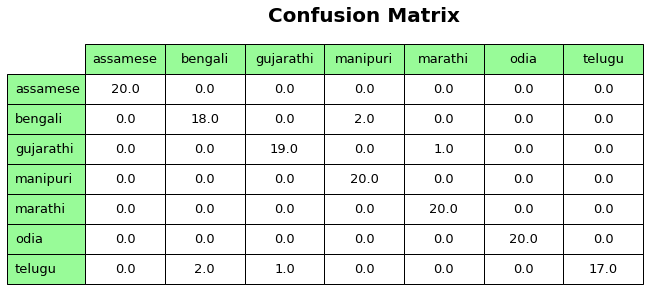

In [9]:
conf_matrix,Language_map,acc = test(GMM_model)
Languages = sorted([os.path.basename(l) for l in os.listdir(maindir)])
fig = plt.figure(figsize=(10,5))
data = conf_matrix
columns = Languages
rows = Languages
plt.axis('off')
the_table = plt.table(cellText=data,rowLabels=rows, colLabels=columns, rowColours =["palegreen"]*10, colColours =["palegreen"]*10 ,cellLoc='center',loc='center')
plt.title('Confusion Matrix', fontweight ="bold", fontsize=20) 
the_table.set_fontsize(20)
the_table.scale(1,2.5)

print("\n------------------------------------")
print("Best model obtained using N_gmm=",N,"\n")
print("Accuracy:",100*acc,"%")
print("------------------------------------\n")

plt.show()

In [10]:
N_gmm = [8,16,32,64,128,256]
N=0
GMM_model={}
accuracy=0
no_of_epochs=100
for i in N_gmm:
  print("Training started using N_gmm=",i,"\n")
  model = train(i,no_of_epochs)
  conf_matrix,Language_map,acc = test(model)
  print("AccuracyL",100*acc,"\n")
  if acc > accuracy:
    GMM_model = model
    N=i
    accuracy = acc

Training started using N_gmm= 8 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 92.85714285714286 

Training started using N_gmm= 16 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 93.57142857142857 

Training started using N_gmm= 32 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 95.0 

Training started using N_gmm= 64 

Training model for odia
Training model for manipuri
Training model for marathi
Training model for bengali
Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 95.0 

Training st


------------------------------------
Best model obtained using N_gmm= 256 

Accuracy: 96.42857142857143 %
------------------------------------



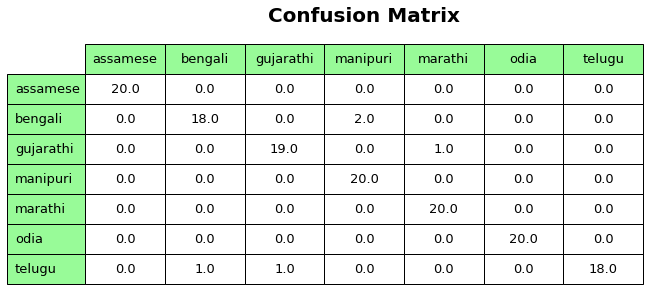

In [11]:
conf_matrix,Language_map,acc = test(GMM_model)
Languages = sorted([os.path.basename(l) for l in os.listdir(maindir)])
fig = plt.figure(figsize=(10,5))
data = conf_matrix
columns = Languages
rows = Languages
plt.axis('off')
the_table = plt.table(cellText=data,rowLabels=rows, colLabels=columns, rowColours =["palegreen"]*10, colColours =["palegreen"]*10 ,cellLoc='center',loc='center')
plt.title('Confusion Matrix', fontweight ="bold", fontsize=20) 
the_table.set_fontsize(20)
the_table.scale(1,2.5)

print("\n------------------------------------")
print("Best model obtained using N_gmm=",N,"\n")
print("Accuracy:",100*acc,"%")
print("------------------------------------\n")

plt.show()

In [12]:
N_gmm = [8,16,32,64,128,256]
N=0
GMM_model={}
accuracy=0
no_of_epochs=50
for i in N_gmm:
  print("Training started using N_gmm=",i,"\n")
  model = train(i,no_of_epochs)
  conf_matrix,Language_map,acc = test(model)
  print("AccuracyL",100*acc,"\n")
  if acc > accuracy:
    GMM_model = model
    N=i
    accuracy = acc

Training started using N_gmm= 8 

Training model for odia
Training model for manipuri


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for marathi
Training model for bengali


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for assamese
Training model for gujarathi
Training model for telugu
AccuracyL 92.14285714285714 

Training started using N_gmm= 16 

Training model for odia
Training model for manipuri


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for marathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for bengali
Training model for assamese


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for gujarathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for telugu


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


AccuracyL 92.85714285714286 

Training started using N_gmm= 32 

Training model for odia
Training model for manipuri
Training model for marathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for bengali


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for assamese


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for gujarathi
Training model for telugu


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


AccuracyL 94.28571428571428 

Training started using N_gmm= 64 

Training model for odia


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for manipuri


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for marathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for bengali


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for assamese


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for gujarathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for telugu


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


AccuracyL 93.57142857142857 

Training started using N_gmm= 128 

Training model for odia


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for manipuri


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for marathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for bengali


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for assamese


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for gujarathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for telugu


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


AccuracyL 95.0 

Training started using N_gmm= 256 

Training model for odia


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for manipuri


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for marathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for bengali


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for assamese


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for gujarathi


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


Training model for telugu


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


AccuracyL 96.42857142857143 




------------------------------------
Best model obtained using N_gmm= 256 

Accuracy: 96.42857142857143 %
------------------------------------



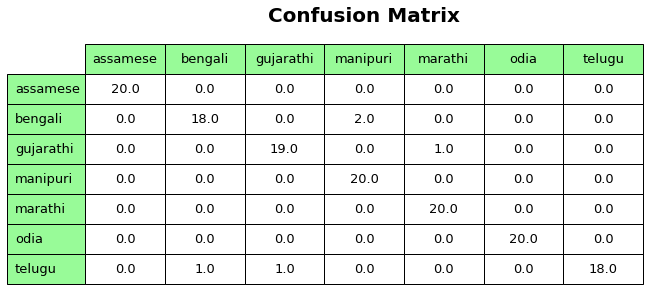

In [13]:
conf_matrix,Language_map,acc = test(GMM_model)
Languages = sorted([os.path.basename(l) for l in os.listdir(maindir)])
fig = plt.figure(figsize=(10,5))
data = conf_matrix
columns = Languages
rows = Languages
plt.axis('off')
the_table = plt.table(cellText=data,rowLabels=rows, colLabels=columns, rowColours =["palegreen"]*10, colColours =["palegreen"]*10 ,cellLoc='center',loc='center')
plt.title('Confusion Matrix', fontweight ="bold", fontsize=20) 
the_table.set_fontsize(20)
the_table.scale(1,2.5)

print("\n------------------------------------")
print("Best model obtained using N_gmm=",N,"\n")
print("Accuracy:",100*acc,"%")
print("------------------------------------\n")

plt.show()